In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

import youtokentome as yttm

import utils
from utils.base import get_params_number, train_loop, init_random_seed, save_texts_to_file
from utils.poetry import LanguageModelDataset, load_chunks, GreedyGenerator, BeamGenerator
from utils.transformer_tools import *

init_random_seed(1702)

In [2]:
# # Предобработка изначального файла, кодировка, уничтожение пустых строк

# with open("datasets/TLOTR.txt", encoding="utf-8") as input_file:
#     horus = input_file.read().split('\n')
#     horus = [value for value in horus if value != ""]
#     # horus = [value.replace(u'\xa0', u' ') for value in horus]

# with open("datasets/TLotR_red.txt", "w", encoding="utf-8") as f:
#     for line in horus:
#         f.write(f"{line}\n")

In [2]:
horus = load_chunks("./datasets/TLotR_red.txt", chunk_size=300)

ALL_LEN = len(horus)
print(ALL_LEN)
len_for_steps = int(ALL_LEN / 3)
horus_for_GAN = horus[len_for_steps * 2:]
horus = horus[:len_for_steps * 2]
print(len(horus))
print(len(horus_for_GAN))

16825
11216
5609


In [3]:
horus_train, horus_test = train_test_split(horus, test_size=0.3)

print('Размер обучающей выборки', len(horus_train))
print('Размер валидационной выборки', len(horus_test))

Размер обучающей выборки 7851
Размер валидационной выборки 3365


In [4]:
BPE_MODEL_FILENAME = './models/My_models/lord_bpe_1000_new.yttm'

# TRAIN_TEXTS_FILENAME = './datasets/lord_train.txt'
# save_texts_to_file(horus, TRAIN_TEXTS_FILENAME)
# yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME)

tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ e t a o n h s r i d l u w g m f y c , . b p ' k v I T B S A ! F H G W ; - M ` E ? : _ R N O L D Y P q C j x z " – U ) ( K V 1 Q J 9 4 3 2 0 7 6 8 5 Z * X = / ▁t he ▁a ▁the in ▁s ▁w nd re ▁o ▁h ou ▁b ▁f ▁and er ed ing at ll it ▁m ▁c ▁l ▁of is ar or en ▁d as ▁to ▁th ▁n es ro ▁he ▁g an id ▁in on ow ▁' ▁I ad ut ▁p ▁be ot ▁y ▁T gh om ld ▁e ▁it ▁st ▁sa ▁was ▁we ▁that ▁u ve ▁you le im ir ay ▁on ▁The ly ght ▁ha am et ▁B st ▁not ▁S ▁said ▁his ill oo se ▁as ▁they ver ▁r ur ▁for ▁A ▁F ac ith ▁is ee ▁G and ▁wh ▁sh al il ight ▁H ▁with ain all ard ▁re ,' ke ould .' ▁had ▁M ▁an ent her ▁at ic ore s, if ome ▁` ast ▁have ▁were ▁him s. red rod ▁but ▁E ▁up ▁W ag ind ▁them ong ▁k th rodo ▁le ▁Frodo rom ▁or ▁do ▁all e. e, ▁see ▁He ▁from nt pp ▁fe ood ch ▁ne ack ▁are ri ▁their ter 's ▁gre ▁sp ▁li ▁R ▁ho ▁there ▁no ▁go ▁now ▁su ▁ag ▁me ▁out ound ▁will ▁But orn ▁so ▁if ook !' ess um ord ry own ame ce ▁kn ▁al ▁O ▁whe ough out ▁long to ust ol ▁'I ▁L ell ark ▁my ▁ro ven ▁cl ▁ab ▁again ▁

In [5]:
train_token_ids = tokenizer.encode(horus_train, bos=True, eos=True)
test_token_ids = tokenizer.encode(horus_test, bos=True, eos=True)

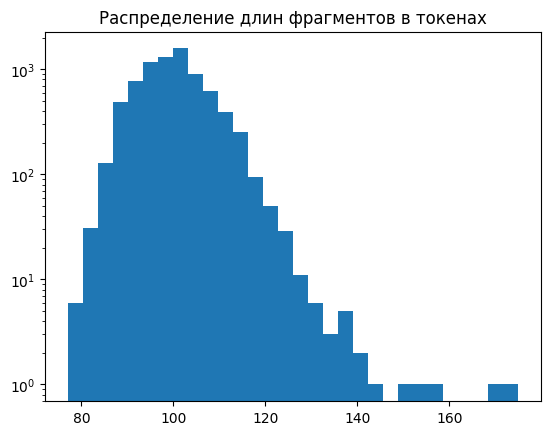

In [6]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log')

In [7]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке', unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


In [8]:
CHUNK_LENGTH = 100

train_dataset = LanguageModelDataset(train_token_ids, chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids, chunk_length=CHUNK_LENGTH)

In [9]:
tokenizer.decode(list(train_dataset[500]))

["ouses than King Theoden's. Was there a date on the barrels?' 'Yes,' said Pippin. 'It was the 1417 crop, that is last year's; no, the year before, of course, now: a good year.' 'Ah well, whatever evil was afoot is over now, I hope; or else it is beyond our reach at present,' said Aragorn. '",
 "es than King Theoden's. Was there a date on the barrels?' 'Yes,' said Pippin. 'It was the 1417 crop, that is last year's; no, the year before, of course, now: a good year.' 'Ah well, whatever evil was afoot is over now, I hope; or else it is beyond our reach at present,' said Aragorn. 'Y"]

In [10]:
model = Language_Model(
    vocab_size = tokenizer.vocab_size(),
    embedding_size = 256,
    backbone = Transformer_Encoder(
        nn.TransformerEncoderLayer(
            d_model = 256,
            nhead = 16,
            dim_feedforward = 512,
            dropout = 0.3
        ),
        num_layers=5
    ),
    emb_dropout = 0.2
)
print('Количество параметров', get_params_number(model))

Количество параметров 3148520


In [12]:
loss_history_all, best_model, optimizer = train_loop(
    model,
    train_dataset,
    test_dataset,
    lm_cross_entropy,
    # save_path="./models/My_models/War/war_2/",
    need_to_save=False,
    # lr=1e-4,
    lr=1e-4,
    epoch_n=2000,
    batch_size=128,
    device='cuda',
    early_stopping_patience=50,
    early_optimizer_SD=optimizer_SD,
    max_batches_per_epoch_train=1000,
    max_batches_per_epoch_val=1000,
    lr_scheduler_ctor=lr_scheduler,
    need_to_gen=True,
    tokenizer=tokenizer,
    pharse="For the king and "
)

Эпоха 0
Эпоха: 62 итераций, 7.34 сек
Среднее значение функции потерь на обучении 3.530923704947195
Среднее значение функции потерь на валидации 3.4701372252570257
Новая лучшая модель!
For the king and he was a great pale sky of the Emyn Muil, and the Dwarves of the Dark Lord, and the Mountains of Moria.

Эпоха 1
Эпоха: 62 итераций, 5.95 сек
Среднее значение функции потерь на обучении 3.530762514760417
Среднее значение функции потерь на валидации 3.467468985804805
Новая лучшая модель!
For the king and held his hand. `Nothing! ' he said. `No! ' he said. `No! ' he said. `No! ' he said. `No! ' said

Эпоха 2
Эпоха: 62 итераций, 5.90 сек
Среднее значение функции потерь на обучении 3.526681976933633
Среднее значение функции потерь на валидации 3.4667891926235623
Новая лучшая модель!
For the king and a great power of the Enemy. The Dark Lord of Gondor was the Enemy of the Enemyn Muil, and the Ene

Эпоха 3
Эпоха: 62 итераций, 5.86 сек
Среднее значение функции потерь на обучении 3.52649194578970

In [13]:
torch.save(best_model.state_dict(), "./models/Lord/4/Lord.pth")
torch.save(optimizer.state_dict(), './models/Lord/4/Lord_opt.pth')

In [14]:
loss_history_all = [str(line) for line in loss_history_all]
save_texts_to_file(loss_history_all, "./models/Lord/4/Lord_4.txt")

In [15]:
optimizer_SD = torch.load('./models/Lord/4/Lord_opt.pth')
model.load_state_dict(torch.load('./models/Lord/4/Lord.pth'))

<All keys matched successfully>

In [16]:
beam_generator = BeamGenerator(model, tokenizer)

In [18]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the middle of', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the middle of the Brandybuck. The Hobbits of Buckland and the Brandywine Brandywine Buckland, and Buckland, and Brandy
In the middle of the White Tower of the Westfold, and the Ring of the Wise of the Ring-lame of Amonath, and the King of the Ring-
In the middle of the companions of the White Celebrances of the Doom, and the Guldor. Few of the Misty Mountains
In the middle of Minas Tirith, and the son of Anon, the Elendil of the Three, and the Tower of Sauron and the Sword
In the middle of the _Tree_. _The Present" said to the White Treebeard. "Reversent" he said, "I says". "


In [28]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('Today Sun is', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

Today Sun is the Black Riders of the Brandywine Buckland Buckland, and the Brandybadil, and the Brandybucks of the H
Today Sun is awise of the Great River, and the Gladden of the Mountains of the Dark Lords of Mordor, and the Galadriel
Today Sun is in the Brandywine of the End. The Brandy Mountains of the Endil, and the Great River, and the Lord of Endil
Today Sun is in the Eastyn Muil of the Mountains of Mor, and the Mountains of the Mountains of Mordoria, and the Mordor
Today Sun is in the Shire, and the Hobbiton of the Brandywine of the Brandybucks of the Bucklands of Buckland, and the Buckland


In [29]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('For the king and ', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

For the king and the<EOS>
For the king and the banks of the Mountains of the Mountains of Mountains, and the Mountains of the Mordor, and the Mordor of Middle-ear
For the king and the banks of the Silvern and the Mountains of the Mountains of Mordor. The Mountains of the Mountains of the Mountains and
For the king and drinks of the Mountains of the Mountains, and the Mountains of the Mountains of the Mountains of Mirkworia, and the
For the king and power of the Enemy island of the Emyn Mountains, and the Mountains of the Moria, and the Middle-earth.


In [42]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('For the king and ', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

For the king and the raws of the raises of Mirkwood. After a while they kept the swords of the Misty Mountains and the
For the king and the Riders of Lуrien, and the Galadhras of Galadriel of the Galadriel of the Galadhrim, and
For the king and songs of the world, and of the Elves, the Swords of the Mark, and the Mark Tooks and the Sea. Oncement
For the king and the Great Wate, he would not say: "The Lord of Mord Minas Tirith. Minas Tirith? ' `Oncause
For the king and the glory of the Sea came from the Eorling Windnessemen. The Dъrades of the Lord of Gondor, and Shadow


In [37]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('Today Sun is', beamsize=5, return_hypotheses_n=1, temperature=0.5, alpha=0.3)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

Today Sun is Bill Feratterbadoff. To the Brandy Brandy Hall (as the Brandywine Bridge, and the Brandyb
Today Sun is called.' 'There is a Black Galad,' said Frodo; 'but I have seen the Buckleburdy to the Bridge of Buckland
Today Sun is a Brown Lady's foot,' she answered. 'But I am afraid the Dwarf-bearer of the Bridge; but I have seen the Blord
Today Sun is the Mark, and the Master of Mordor. Mordor is a worth. I have not heard of the Black Lord of Lуrien and Den
Today Sun is, and the Great Sea.' `No, no! ' said Faramir, ' said Faramir, `but not to the Company. `These are
